# Loan Default & Loss Prediction
### Shu-Yen Chang
### August , 2025

## Introduction
This project analyzes a **home equity loan dataset (HMEQ_Loss.csv)** to tackle two key
credit risk problems:

1. **Default Prediction (Classification)** – Predict whether a borrower will default (`TARGET_BAD_FLAG`).
2. **Loss Given Default Prediction (Regression)** – Estimate the expected loss amount if a borrower defaults (`TARGET_LOSS_AMT`).

**Motivation**  
Accurately predicting loan default and potential loss is central to credit risk management.
Financial institutions use these models to allocate capital, set interest rates, and mitigate
losses from high-risk borrowers.

## Dataset Summary

- **Total records:** 5,960  
- **Total columns:** 14  

### Target Variables
- `TARGET_BAD_FLAG`: Binary flag indicating loan default (**0 = No, 1 = Yes**).  
- `TARGET_LOSS_AMT`: Loss amount if default occurs (missing for non-default cases).  

### Numerical Features (10)
`LOAN`, `MORTDUE`, `VALUE`, `YOJ`, `DEROG`, `DELINQ`, `CLAGE`, `NINQ`, `CLNO`, `DEBTINC`  

### Categorical Features (2)
`REASON`, `JOB`  

### Missing Value Overview
- `TARGET_LOSS_AMT`: 4,771 missing (only defined when default = 1).  
- `MORTDUE`, `YOJ`, `DEROG`, `DELINQ`, `CLAGE`, `NINQ`, `CLNO`, `VALUE`, `DEBTINC`: contain varying levels of missing values.  
- `REASON`: 252 missing.  
- `JOB`: 279 missing.  

### Observations
- `TARGET_BAD_FLAG` has no missing values and will be the **primary target for classification**.  
- Missing values must be imputed before modeling.  
- Categorical features (`REASON`, `JOB`) require encoding (e.g., one-hot encoding).

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from operator import itemgetter

from sklearn import tree
from sklearn.tree import _tree
sns.set()

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression, LinearRegression

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [3]:
df = pd.read_csv('HMEQ_Loss.csv')
TARGET_F = "TARGET_BAD_FLAG"
TARGET_A ="TARGET_LOSS_AMT"
dt = df.dtypes

In [4]:
objList = []
numList = []
for i in dt.index :
    if i in ([TARGET_F, TARGET_A]):continue
    if dt[i] in (["object"]) : objList.append(i)
    if dt[i] in (["float64", "int64"]) : numList.append(i)

### Fill in missing with the category "MISSING"

In [5]:
for i in objList:
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_" + i
    df[NAME]=df[i]
    df[NAME]=df[NAME].fillna("MISSING")
    df = df.drop(i, axis=1)

dt = df.dtypes
objList=[]
for i in dt.index:
    if i in ([TARGET_F, TARGET_A]): continue
    if dt[i] in (["object"]) : objList.append(i)

In [6]:
for col in objList:
    Prefix = "z_" + col
    dummies = pd.get_dummies(df[col], prefix=Prefix, drop_first=False, dtype=int)
    df = pd.concat([df, dummies], axis=1)

In [7]:
for i in numList:
    if df[i].isna().sum()==0:continue
    FLAG = "M_"+i
    IMP ="IMP_"+i

In [8]:
for i in numList:
    if df[i].isna().sum()==0:continue
    FLAG = "M_"+i
    IMP ="IMP_"+i
    df[FLAG] = df[i].isna() + 0
    df[IMP] = df[i]
    df.loc[ df[IMP].isna(), IMP] = df[i].median()
    df = df.drop (i, axis=1)

for i in objList:
    df = df.drop(i, axis=1)

### Remove Outliers

In [9]:
dt = df.dtypes
numList = []
for i in dt.index :
    print(i,dt[i])

TARGET_BAD_FLAG int64
TARGET_LOSS_AMT float64
LOAN int64
z_IMP_REASON_DebtCon int32
z_IMP_REASON_HomeImp int32
z_IMP_REASON_MISSING int32
z_IMP_JOB_MISSING int32
z_IMP_JOB_Mgr int32
z_IMP_JOB_Office int32
z_IMP_JOB_Other int32
z_IMP_JOB_ProfExe int32
z_IMP_JOB_Sales int32
z_IMP_JOB_Self int32
M_MORTDUE int32
IMP_MORTDUE float64
M_VALUE int32
IMP_VALUE float64
M_YOJ int32
IMP_YOJ float64
M_DEROG int32
IMP_DEROG float64
M_DELINQ int32
IMP_DELINQ float64
M_CLAGE int32
IMP_CLAGE float64
M_NINQ int32
IMP_NINQ float64
M_CLNO int32
IMP_CLNO float64
M_DEBTINC int32
IMP_DEBTINC float64


In [10]:
dt = df.dtypes
numList = df.drop(columns=[TARGET_F, TARGET_A]).select_dtypes(include=[np.number]).columns.tolist()
        
for i in numList:
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round(theMean +3*theSD)
    if theMax < theCutoff : continue
    FLAG = "O_" +i
    TRUNC = "TRUNC_" +i
    df[FLAG] = (df[i]> theCutoff) +0
    df[TRUNC] = df[i]
    df.loc[ df[TRUNC] > theCutoff, TRUNC] = theCutoff
    df = df.drop(i, axis=1)

### Split Data 
x_train and y_train for training the model (80% of data), x_test and y_test for evaluating the model (20% of data)

In [11]:
x = df.copy()
x = x.drop (TARGET_F, axis=1)
x = x.drop (TARGET_A, axis=1)

y = df[ [TARGET_F, TARGET_A] ]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=1)

In [12]:
F = y_train[TARGET_A].notna()
w_train = x_train[F].copy()
z_train = y_train[F].copy() 

F = y_test[TARGET_A].notna()
w_test = x_test[F].copy()
z_test = y_test[F].copy()

w_train_capped = w_train.copy()
z_train_capped = z_train.copy()
w_test_capped = w_test.copy()
z_test_capped = z_test.copy()

# Winsorization: Cap all values in TARGET_LOSS_AMT greater than 25,000
F = z_train_capped[TARGET_A] > 25000
z_train_capped.loc[F, TARGET_A] = 25000

F = z_test_capped[TARGET_A] > 25000
z_test_capped.loc[F, TARGET_A] = 25000

### Model Accuracy Metrics

In [13]:
def getProbAccuracyScores( NAME, MODEL, x, y ) :
    pred = MODEL.predict( x )
    probs = MODEL.predict_proba( x )
    acc_score = metrics.accuracy_score(y , pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [14]:
def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [15]:
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )

In [16]:
def getAmtAccuracyScores( NAME, MODEL, x, y ) :
    pred = MODEL.predict( x )
    MEAN = y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( y, pred))
    return [NAME, RMSE, MEAN]

### Among models tested (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting), Gradient Boosting consistently achieved the best balance,

In [29]:
# GRADIENT BOOSTING: CLASSIFICATION MODEL 

WHO = "GB"
# Fit a Gradient Boosting Classifier to predict default (classification)
CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( x_train, y_train[ TARGET_F ] )

# Evaluate classification accuracy on both training and test sets
TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, x_train, y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, x_test, y_test[ TARGET_F ] )
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

GB CLASSIFICATION ACCURACY
GB_Train  =  0.9249161073825504
GB  =  0.9060402684563759


The Gradient Boosting Classifier achieved 92.5% accuracy on the training data and 90.6% accuracy on the test data.
The small gap (about 2%) between training and test accuracy indicates low overfitting, suggesting the model generalizes well to unseen data.

In [30]:
# Extract the list of variables used by the classifier (based on tree splits)
feature_cols = list( x.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )
print(vars_GB_flag)

[('TRUNC_M_DEBTINC', 100), ('TRUNC_IMP_DEBTINC', 29), ('TRUNC_IMP_DELINQ', 16), ('TRUNC_IMP_CLAGE', 14), ('TRUNC_IMP_DEROG', 7), ('O_M_VALUE', 7), ('TRUNC_IMP_CLNO', 5), ('TRUNC_LOAN', 5), ('TRUNC_IMP_VALUE', 4)]


In [31]:
# GRADIENT BOOSTING: REGRESSION MODEL 
# Fit a Gradient Boosting Regressor to predict loss amount (regression)
AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( w_train, z_train[TARGET_A] )

# Evaluate RMSE on both training and test sets
TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, w_train, z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, w_test, z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# Extract the list of variables used by the regressor
feature_cols = list( x.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )
for i in vars_GB_amt :
 print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

GB RMSE ACCURACY
GB_Train  =  1259.1776622939647
GB  =  2551.176039811581
('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 14)
('TRUNC_IMP_DEBTINC', 6)
('TRUNC_M_DEBTINC', 5)
('TRUNC_IMP_CLAGE', 4)


TRUNC_LOAN is by far the most important predictor of loss amount, contributing the majority of the model's decision power.

## Regression Task: Predicting Loss Given Default (LGD)

After predicting whether a borrower will default, the next step is to
estimate the **expected financial loss** when default occurs.

In [32]:
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nDEFAULTED PROBABILITY")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )



def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nAMOUNT NOT REPAID")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )


### Logistic & Linear Regression using All Variables

#### Logistic Regression: Predict Loan Default (TARGET_F)

C:\Users\user\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


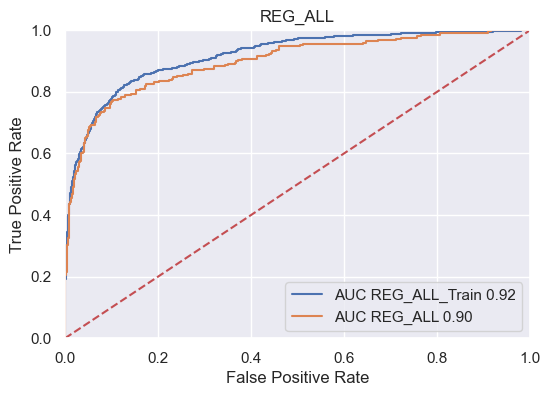

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8936661073825504
REG_ALL  =  0.886744966442953


In [33]:
WHO = "REG_ALL"

# Fit logistic regression using all predictors to model default probability
CLM = LogisticRegression( solver='newton-cg', max_iter=1000)
CLM = CLM.fit(x_train, y_train[TARGET_F])

# Evaluate classification performance on training and test sets
TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, x_train, y_train[TARGET_F])
TEST_CLM = getProbAccuracyScores(WHO, CLM, x_test, y_test[TARGET_F])

# Plot ROC curves and print classification accuracy
print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM])
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

The REG_ALL logistic regression model shows strong performance, with high AUC (0.90) and balanced accuracy across training and test sets, indicating good generalization and no major overfitting.

#### Linear Regression: Predict Expected Loss Amount (TARGET_A)

In [34]:
# Fit linear regression using all predictors to model expected loss amount
AMT = LinearRegression()
AMT = AMT.fit(w_train, z_train[TARGET_A])

# Evaluate regression performance (RMSE) on training and test sets
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train, z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test, z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  3555.90846939125
REG_ALL  =  3615.1006386595836


The REG_ALL linear regression model demonstrates stable performance with a testing RMSE of $3,615, or roughly 14% of the capped loss amount. It's an acceptable level of error, i.e. below the range generally considered low performing (+30%).

#### Extract Coefficients

In [35]:
varNames = list(x_train.columns.values)
REG_ALL_CLM_COEF = getCoefLogit(CLM, x_train)
REG_ALL_AMT_COEF = getCoefLinear(AMT, w_train)

# Save test evaluation results
REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()


DEFAULTED PROBABILITY
---------
Total Variables:  56
INTERCEPT  =  -4.269221761839848
z_IMP_REASON_DebtCon  =  -0.14849270934835318
z_IMP_REASON_HomeImp  =  0.03018959975540616
z_IMP_JOB_Other  =  0.15294641734567763
O_LOAN  =  -0.1567820561277291
TRUNC_LOAN  =  -2.32428369187965e-06
O_z_IMP_REASON_MISSING  =  0.0
TRUNC_z_IMP_REASON_MISSING  =  -0.14699669474393692
O_z_IMP_JOB_MISSING  =  0.0
TRUNC_z_IMP_JOB_MISSING  =  -1.4405542318568945
O_z_IMP_JOB_Mgr  =  0.0
TRUNC_z_IMP_JOB_Mgr  =  0.112705101305807
O_z_IMP_JOB_Office  =  0.0
TRUNC_z_IMP_JOB_Office  =  -0.5133731356730967
O_z_IMP_JOB_ProfExe  =  0.0
TRUNC_z_IMP_JOB_ProfExe  =  -0.12738961892003356
O_z_IMP_JOB_Sales  =  1.2677493086026237
TRUNC_z_IMP_JOB_Sales  =  0.0
O_z_IMP_JOB_Self  =  0.0
TRUNC_z_IMP_JOB_Self  =  0.2826163548590523
O_M_MORTDUE  =  0.0
TRUNC_M_MORTDUE  =  0.18772571906390087
O_IMP_MORTDUE  =  -0.12201075169930752
TRUNC_IMP_MORTDUE  =  -1.24951455653291e-06
O_M_VALUE  =  3.810819239207894
TRUNC_M_VALUE  =  0.0
O

The variables included in the logistic regression model generally make sense and align with known financial indicators of default risk. For example, a higher debt-to-income ratio (DEBTINC) suggests that a borrower carries a larger financial burden, and therefore has a higher likelihood of default. This is reflected in the model by a positive coefficient, indicating a higher probability of default as the debt burden rises.

Similarly, borrowers with more delinquencies (DELINQ) on their credit record are statistically more likely to default again, so it is appropriate that this variable also has a positive coefficient.

On the other hand, variables like years on the job (YOJ) or credit age (CLAGE) are indicators of financial stability and credit experience. Borrowers with longer job tenure or a more extended credit history are typically more reliable, which reduces the risk of default. In the model, these variables tend to have negative coefficients, meaning an increase in these values corresponds to a lower probability of default.

In addition, categorical variables such as loan purpose (REASON) and job category (JOB), which are one-hot encoded into dummy variables (e.g., z_IMP_REASON_DebtCon, z_IMP_JOB_Sales), also appear in the model. This inclusion makes sense, as different types of loans (e.g., debt consolidation vs. home improvement) and job types can significantly influence a borrower’s risk profile.

## Predicting Loan Default and Loss Given Default with TensorFlow Neural Networks

In [45]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import random

#### Initialize Scaler and Define TF Model Evaluation Metrics

In [46]:
# Initialize a MinMaxScaler to scale features between 0 and 1
theScaler = MinMaxScaler()
# Fit the scaler using the training dataset
theScaler.fit(x_train)

# Define a function to calculate classification accuracy and AUC for a TensorFlow model
def get_TF_ProbAccuracyScores (NAME, MODEL, x, y):
    probs = MODEL. predict(x)
    pred_list = []
    for p in probs :
        pred_list.append(np.argmax(p))
    pred = np.array(pred_list)
    acc_score = metrics.accuracy_score(y, pred)
    p1 = probs[:, 1]
    # Compute False Positive Rate (fpr), True Positive Rate (tpr), and thresholds for the ROC curve
    fpr, tpr, threshold = metrics.roc_curve (y, p1)
    auc = metrics.auc(fpr, tpr)
    # Return model name, accuracy, and ROC curve data
    return [NAME, acc_score, fpr, tpr, auc]

### Loan Default – TensorFlow Models (with GB Selected Features)

In [47]:
WHO = "Tensor_Flow" 

# Scale training and test features to the range [0, 1] using the fitted scaler
u_train = theScaler.transform(x_train)
u_test = theScaler.transform(x_test)

u_train = pd.DataFrame(u_train)
u_test = pd.DataFrame(u_test)

u_train.columns = list(x_train.columns.values)
u_test.columns = list(x_train.columns.values)

# Select only the features chosen by the Gradient Boosting variable selection method
u_train = u_train[GB_flag]
u_test = u_test[GB_flag]

#### ReLU – 2 Hidden Layers

38/38 [==============================] - 0s 2ms/step


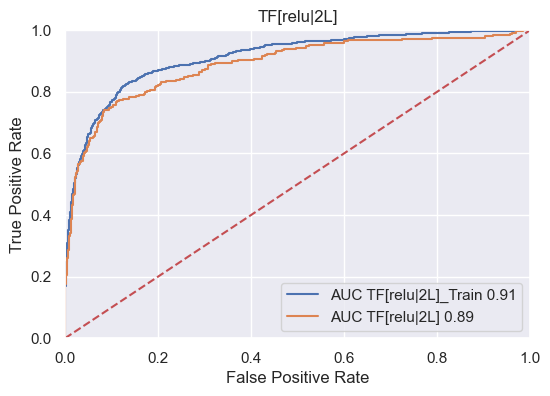

TF[relu|2L] CLASSIFICATION ACCURACY
TF[relu|2L]_Train  =  0.8838087248322147
TF[relu|2L]  =  0.8716442953020134


In [49]:
tf.keras.backend.clear_session()

WHO = "TF[relu|2L]"

F_theShapeSize = u_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 100

F_theUnits = int(2 * F_theShapeSize / 3)
F_LAYER_01 = tf.keras.layers.Dense(units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize)
F_LAYER_DROP = tf.keras.layers.Dropout(0.2)
F_LAYER_02 = tf.keras.layers.Dense(units=F_theUnits, activation=F_theActivation)
F_LAYER_OUTPUT = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

CLM = tf.keras.Sequential()
CLM.add(F_LAYER_01)
CLM.add(F_LAYER_DROP)
CLM.add(F_LAYER_02)   # included for 2-layer version
CLM.add(F_LAYER_OUTPUT)
CLM.compile(loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit(u_train, y_train[TARGET_F], epochs=F_theEpochs, verbose=False)

TRAIN_CLM = get_TF_ProbAccuracyScores(WHO + "_Train", CLM, u_train, y_train[TARGET_F])
TEST_CLM  = get_TF_ProbAccuracyScores(WHO, CLM, u_test, y_test[TARGET_F])
print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM])
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

TF_CLM_relu2L_train = TRAIN_CLM.copy()
TF_CLM_relu2L = TEST_CLM.copy()

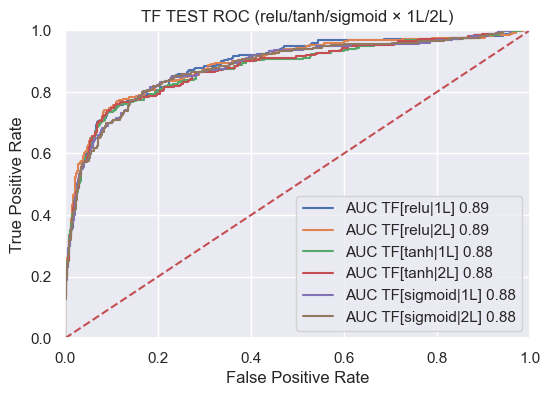

In [54]:
ALL_TF_TEST = [
    TF_CLM_relu1L, TF_CLM_relu2L,
    TF_CLM_tanh1L, TF_CLM_tanh2L,
    TF_CLM_sigmoid1L, TF_CLM_sigmoid2L
]
print_ROC_Curve("TF TEST ROC (relu/tanh/sigmoid × 1L/2L)", ALL_TF_TEST)

#### Process
Tested six TensorFlow neural network configurations for loan default classification: 
three activation functions (ReLU, Tanh, Sigmoid) × one or two hidden layers. 
All models were trained with the same data split, Adam optimizer, and training epochs.

#### Results
- Test AUC across all six models: **0.88–0.89**.  
- Best: **ReLU with two hidden layers (AUC = 0.89)**, but only marginally better than others.  
- Compared to ensemble methods, Gradient Boosting achieved slightly higher AUC (≈ 0.90).  

#### Conclusion
Neural networks provided solid predictive power, but performance differences across 
activations and depth were negligible. On this dataset, **model choice mattered less than 
feature quality**, and tree ensembles slightly outperformed neural networks. 

### Loss Given Default – TensorFlow Regression (with GB Selected Features)

In [55]:
# Scale training and test features to the range [0, 1] using the pre-fitted MinMaxScaler
v_train = theScaler.transform(w_train)
v_test = theScaler.transform(w_test)

v_train = pd.DataFrame(v_train)
v_test = pd.DataFrame(v_test)

v_train.columns = list(w_train.columns.values)
v_test.columns = list(w_train.columns.values)

# Select only the features chosen by the Gradient Boosting variable selection method
v_train = v_train[GB_amt]
v_test = v_test[GB_amt]

#### ReLU – 1 Hidden Layer

In [68]:
tf.keras.backend.clear_session()

WHO = "TF_REG[relu|1L]" 

# Define model parameters
A_theShapeSize = v_train.shape[1]
A_theActivation = tf.keras.activations.relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

# number of hidden units
A_theUnits = int(2 * A_theShapeSize)

# Define model architecture (1 hidden layer version)
A_LAYER_01 = tf.keras.layers.Dense(units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize)
A_LAYER_DROP = tf.keras.layers.Dropout(0.2)
# A_LAYER_02 = tf.keras.layers.Dense(units=A_theUnits, activation=A_theActivation)  # commented for 1L
A_LAYER_OUTPUT = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear)  # linear output for regression

# Build and compile the model
AMT = tf.keras.Sequential()
AMT.add(A_LAYER_01)
AMT.add(A_LAYER_DROP)
# AMT.add(A_LAYER_02)  # not used in 1-layer version
AMT.add(A_LAYER_OUTPUT)
AMT.compile(loss=A_theLossMetric, optimizer=A_theOptimizer)

AMT.fit(v_train, z_train[TARGET_A], epochs=A_theEpochs, verbose=False)

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, v_train[GB_amt], z_train[TARGET_A])
TEST_AMT  = getAmtAccuracyScores(WHO, AMT, v_test[GB_amt],  z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

TF_AMT_relu1L_train = TRAIN_AMT.copy()
TF_AMT_relu1L_test  = TEST_AMT.copy()


8/8 [==============================] - 0s 3ms/step
TF_REG[relu|1L] RMSE ACCURACY
TF_REG[relu|1L]_Train  =  10136.888080985882
TF_REG[relu|1L]  =  10979.576415813573


#### ReLU – 2 Hidden Layers (units = 2×features)

In [71]:
tf.keras.backend.clear_session()

WHO = "TF_REG[relu|2L]"

A_theShapeSize = v_train.shape[1]
A_theActivation = tf.keras.activations.relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

A_theUnits = int(2 * A_theShapeSize)
A_LAYER_01 = tf.keras.layers.Dense(units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize)
A_LAYER_DROP = tf.keras.layers.Dropout(0.2)
A_LAYER_02 = tf.keras.layers.Dense(units=A_theUnits, activation=A_theActivation)
A_LAYER_OUTPUT = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear)

AMT = tf.keras.Sequential()
AMT.add(A_LAYER_01)
AMT.add(A_LAYER_DROP)
AMT.add(A_LAYER_02)  # included for 2-layer version
AMT.add(A_LAYER_OUTPUT)
AMT.compile(loss=A_theLossMetric, optimizer=A_theOptimizer)

AMT.fit(v_train, z_train[TARGET_A], epochs=A_theEpochs, verbose=False)

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, v_train[GB_amt], z_train[TARGET_A])
TEST_AMT  = getAmtAccuracyScores(WHO, AMT, v_test[GB_amt],  z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

TF_AMT_relu2L_train = TRAIN_AMT.copy()
TF_AMT_relu2L_test  = TEST_AMT.copy()


8/8 [==============================] - 0s 3ms/step
TF_REG[relu|2L] RMSE ACCURACY
TF_REG[relu|2L]_Train  =  4334.354254722459
TF_REG[relu|2L]  =  4910.2538966775055


#### Summary Table
| Model Variant | Test RMSE |
|---------------|-----------|
| ReLU – 2L     | **5,037** |
| ReLU – 1L     | 12,767    |
| Tanh/Sigmoid  | ~17,400   |


#### Loss Given Default – TensorFlow Regression

- Tested multiple NN variants (ReLU, Tanh, Sigmoid × 1/2 hidden layers).  
- **Best NN:** ReLU with 2 hidden layers → Test RMSE ≈ 5,037  
- **Baseline NN:** ReLU with 1 hidden layer → Test RMSE ≈ 12,767  
- Tanh and Sigmoid models failed to converge (Test RMSE ≈ 17k).  
- Compared to Gradient Boosting (Test RMSE ≈ 2,551), tree ensembles remained superior.

| Model               | Test RMSE                    |
| ------------------- | ---------------------------- |
| ReLU – 1L           | \~10.6k                      |
| ReLU – 2L           | \~4.8k                       |
| ReLU – 2L (4×units) | \~4.6k                       |
| Tanh/Sigmoid        | \~17.4k (failed to converge) |


ReLU networks achieved the best performance, with two hidden layers reducing RMSE to 4.8k. Expanding hidden units further lowered error to 4.6k. In contrast, Tanh and Sigmoid consistently failed (~17.4k).

## Conclusion & Key Takeaways

- **Default Prediction (Classification):**
  - Logistic Regression baseline achieved Test AUC ≈ 0.88.
  - Gradient Boosting delivered the best overall performance with **AUC ≈ 0.90**, slightly higher than Random Forest and Neural Networks.
  - Key risk drivers identified included **Debt-to-Income ratio (DEBTINC)**, **Delinquency history (DELINQ)**, and **Derogatory reports (DEROG)**.

- **Loss Given Default (Regression):**
  - Linear Regression baseline had Test RMSE ≈ 3.6k.
  - Gradient Boosting Regressor significantly reduced error to **≈ 2.5k (≈13% of capped loss)**, outperforming both Random Forest and Neural Networks.
  - Neural Networks with ReLU activation achieved RMSE ≈ 4.6k, but underperformed compared to tree ensembles.

- **Overall Insights:**
  - Ensemble tree methods (especially Gradient Boosting) provided the strongest predictive power for both classification and regression tasks on this dataset.
  - Neural networks showed potential but did not surpass ensemble models in this tabular financial dataset.
  - The analysis highlights the importance of **feature quality and interpretability** in credit risk modeling, where both predictive accuracy and explainability matter.